# QPSK Benchmarking

This notebook benchmarks the BER/SNR, BER/CFO, and BER/STO of a QPSK communication chain.

## Algorithm
1. Generate transmit signal
2. Define reception function
3. Individually scan over SNR, CFO, and STO, measuring BER
4. Plot results

Author: Cole Delong

### Imports and Constants

In [149]:
%reload_ext autoreload
%autoreload 2

import py_utils as pu
from py_utils import visualization as vz
import numpy as np

N_BITS = 10**5

### Transmit chain

In [150]:
bits_tx = np.random.randint(2, size=N_BITS)
sym_tx = pu.coding.diff_encode_psk_symbols(pu.modulation.modulate_qpsk(bits_tx))

SPS = 2
N_RRC_TAPS = SPS*10 + 1
sig_tx = pu.dsp.upsample(sym_tx, SPS)

sig_tx = pu.dsp.rrc_filter(sig_tx, N_RRC_TAPS, SPS)


### Recieve chain function

In [151]:
def receive_chain(sig_rx, sps=SPS, n_rrc_taps=N_RRC_TAPS):
    # Matched filter
    sig_matched = pu.dsp.rrc_filter(sig_rx, N_RRC_TAPS, SPS)

    # Timing recovery
    symbols_sampled = pu.timing_recovery.GardnerSymbolTimingCorrector().process(sig_matched)

    # Carrier recovery
    loop_bw = 1/20
    costas = pu.carrier_recovery.CostasLoopQPSK(loop_bw)
    sym_rot = np.empty_like(symbols_sampled, dtype=np.complex64)
    costas.process(symbols_sampled, sym_rot)

    # Demodulate
    bits_rx = pu.modulation.demodulate_qpsk(pu.coding.diff_decode_psk_symbols(sym_rot))

    return bits_rx

### Scan over SNR

SNR (dB) range: [0, 5, 10, 15, 20, 25, 30]
SNR (dB): 0	BER: 1.803e-01
SNR (dB): 5	BER: 4.413e-02
SNR (dB): 10	BER: 1.730e-03
SNR (dB): 15	BER: 4.400e-04
SNR (dB): 20	BER: 3.700e-04
SNR (dB): 25	BER: 3.700e-04
SNR (dB): 30	BER: 3.600e-04


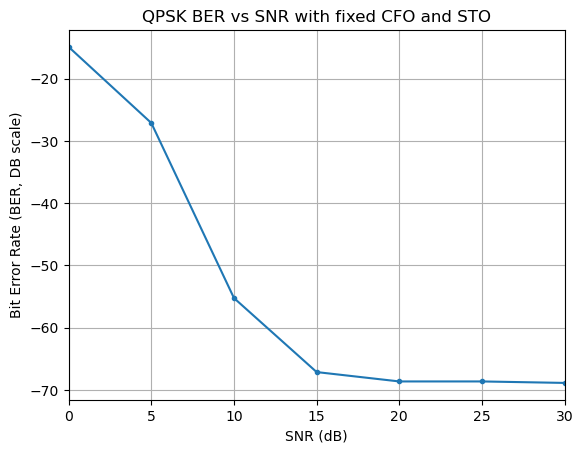

In [152]:
# BER vs SNR with fixed CFO and STO

snr_db_range = range(0, 31, 5)
print(f"SNR (dB) range: {list(snr_db_range)}")

# Constant CFO and STO
CFO_PCT = 0.03  # 3% CFO
STO = 0.3  # fractional symbol offset

sig_chan = sig_tx
sig_chan = pu.channel.apply_cfo(sig_chan, CFO_PCT)
sig_chan = pu.channel.apply_sto(sig_chan, STO)

# Scan over SNR values
ber_values = []
for snr_db in snr_db_range:
    sig_chan_awgn = pu.channel.apply_awgn(sig_chan, snr_db)

    bits_rx = receive_chain(sig_chan_awgn)
    ber = np.sum(bits_tx != bits_rx) / N_BITS
    ber_values.append(ber)
    print(f'SNR (dB): {snr_db}\tBER: {ber:.3e}')

# Plot results
_ = vz.plot_signal(ber_values, x=snr_db_range,
    title="QPSK BER vs SNR with fixed CFO and STO",
    xlabel="SNR (dB)",
    ylabel="Bit Error Rate (BER, DB scale)",
    db=True,)




### Scan over CFO

CFO percent range: [0.   0.01 0.02 0.03 0.04 0.05]
CFO percent offset: 0.000	BER: 4.100e-04
CFO percent offset: 0.010	BER: 4.200e-04
CFO percent offset: 0.020	BER: 4.200e-04
CFO percent offset: 0.030	BER: 4.200e-04
CFO percent offset: 0.040	BER: 6.700e-04
CFO percent offset: 0.050	BER: 1.211e-02


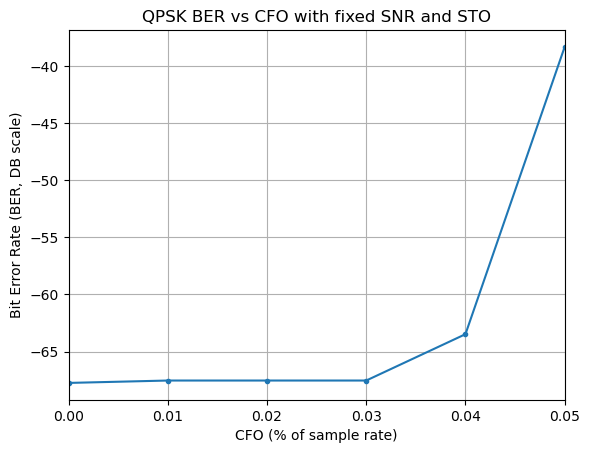

In [153]:
# BER vs CFO with fixed SNR and STO

cfo_pct_range = np.linspace(0, 0.05, 6)
cfo_w_range = cfo_pct_range * 2 * np.pi
print(f"CFO percent range: {cfo_pct_range}")

# Constant SNR and STO
SNR_DB = 20     # dB
STO = 0.3       # fractional symbol offset

sig_chan = sig_tx
sig_chan = pu.channel.apply_sto(sig_chan, STO)
sig_chan = pu.channel.apply_awgn(sig_chan, SNR_DB)


# Scan over CFO values
ber_values = []
for i, cfo in enumerate(cfo_w_range):
    sig_chan_cfo = pu.channel.apply_cfo(sig_chan, w_offset=cfo)

    bits_rx = receive_chain(sig_chan_cfo)
    ber = np.sum(bits_tx != bits_rx) / N_BITS
    ber_values.append(ber)
    print(f'CFO percent offset: {cfo_pct_range[i]:.3f}\tBER: {ber:.3e}')

# Plot results
_ = vz.plot_signal(ber_values, x=cfo_pct_range,
    title="QPSK BER vs CFO with fixed SNR and STO",
    xlabel="CFO (% of sample rate)",
    ylabel="Bit Error Rate (BER, DB scale)",
    db=True,)

### Scan over STO

Fractional timing offset (mu) range: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
STO: 0.00	BER: 3.800e-04
STO: 0.10	BER: 3.400e-04
STO: 0.20	BER: 3.200e-04
STO: 0.30	BER: 4.100e-04
STO: 0.40	BER: 4.400e-04
STO: 0.50	BER: 1.110e-03
STO: 0.60	BER: 7.000e-05
STO: 0.70	BER: 4.000e-05
STO: 0.80	BER: 2.000e-05
STO: 0.90	BER: 2.500e-04
STO: 1.00	BER: 3.000e-05


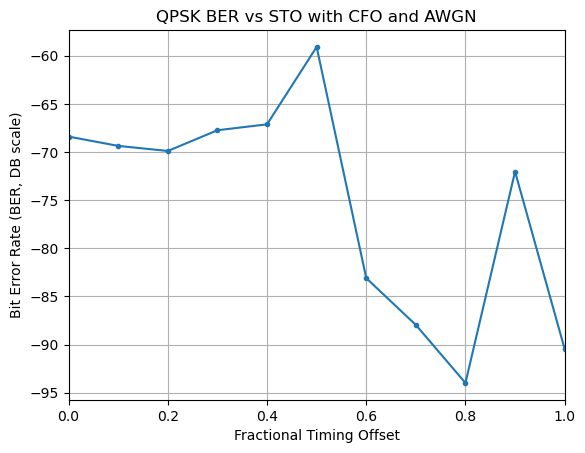

In [154]:
# BER vs SNR with fixed CFO and STO

sto_range = np.linspace(0, 1, 11)
print(f"Fractional timing offset (mu) range: {sto_range}")

# Constant CFO and SNR
CFO_PCT = 0.03  # 3% CFO
SNR_DB = 20     # 20 dB SNR

cfo_w_off = CFO_PCT * 2 * np.pi

sig_chan = sig_tx
sig_chan = pu.channel.apply_cfo(sig_chan, CFO_PCT)
sig_chan = pu.channel.apply_awgn(sig_chan, SNR_DB)


# Scan over SNR values
ber_values = []
for sto in sto_range:
    sig_chan_sto = pu.channel.apply_sto(sig_chan, sto)

    bits_rx = receive_chain(sig_chan_sto)
    ber = np.sum(bits_tx != bits_rx) / N_BITS
    ber_values.append(ber)
    print(f'STO: {sto:.2f}\tBER: {ber:.3e}')


# Plot results
_ = vz.plot_signal(ber_values, x=sto_range,
    title="QPSK BER vs STO with CFO and AWGN",
    xlabel="Fractional Timing Offset",
    ylabel="Bit Error Rate (BER, DB scale)",
    db=True,)
